In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os.path
import sys
import numpy as np
import math
import sklearn.metrics as metrics
from tqdm import tqdm
from gym import Env, spaces
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


from tensorflow.python.keras import backend
from tensorflow.keras.backend import clear_session


import time

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import csv

import tensorflow as tf
import tensorflow.compat.v1 as tf1
import tensorflow.keras as K

from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
import numpy as np
import time
import sys

In [ ]:
#!/usr/bin/env python
import random
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
def read_and_decode(dataset, batch_size, is_training, data_size,n_patients):
    if is_training:
        dataset = dataset.shuffle(buffer_size=data_size, reshuffle_each_iteration=True)
        dataset = dataset.batch(batch_size, drop_remainder=False)
        dataset = dataset.repeat(None)
    else:
        dataset = dataset.prefetch(buffer_size=data_size // batch_size)
        dataset = dataset.batch(batch_size, drop_remainder=False)
        dataset = dataset.repeat(None)
    return dataset

In [ ]:

def initialize_clinical_practice(clinical_cases_feat,clinical_cases_labels,dataset_size,n_classes,is_training,n_patients,set_distribution):

    if is_training:
        _, counts = np.unique(clinical_cases_labels, return_counts=True)

        akiec = np.squeeze(np.take(clinical_cases_feat, np.where(clinical_cases_labels == 0), axis=0))
        akiec_labels = np.squeeze(np.take(clinical_cases_labels, np.where(clinical_cases_labels == 0), axis=0))

        bcc = np.squeeze(np.take(clinical_cases_feat, np.where(clinical_cases_labels == 1), axis=0))
        bcc_labels = np.squeeze(np.take(clinical_cases_labels, np.where(clinical_cases_labels == 1), axis=0))

        bkl = np.squeeze(np.take(clinical_cases_feat, np.where(clinical_cases_labels == 2), axis=0))
        bkl_labels = np.squeeze(np.take(clinical_cases_labels, np.where(clinical_cases_labels == 2), axis=0))

        df = np.squeeze(np.take(clinical_cases_feat, np.where(clinical_cases_labels == 3), axis=0))
        df_labels = np.squeeze(np.take(clinical_cases_labels, np.where(clinical_cases_labels == 3), axis=0))

        mel = np.squeeze(np.take(clinical_cases_feat, np.where(clinical_cases_labels == 4), axis=0))
        mel_labels = np.squeeze(np.take(clinical_cases_labels, np.where(clinical_cases_labels == 4), axis=0))

        nv = np.squeeze(np.take(clinical_cases_feat, np.where(clinical_cases_labels == 5), axis=0))
        nv_labels = np.squeeze(np.take(clinical_cases_labels, np.where(clinical_cases_labels == 5), axis=0))

        vasc = np.squeeze(np.take(clinical_cases_feat, np.where(clinical_cases_labels == 6), axis=0))
        vasc_labels = np.squeeze(np.take(clinical_cases_labels, np.where(clinical_cases_labels == 6), axis=0))

        akiec_set = tf.data.Dataset.from_tensor_slices((akiec, akiec_labels)).shuffle(buffer_size=counts[0],
                                                                                      reshuffle_each_iteration=True).repeat()
        bcc_set = tf.data.Dataset.from_tensor_slices((bcc, bcc_labels)).shuffle(buffer_size=counts[1],
                                                                                reshuffle_each_iteration=True).repeat()
        bkl_set = tf.data.Dataset.from_tensor_slices((bkl, bkl_labels)).shuffle(buffer_size=counts[2],
                                                                                reshuffle_each_iteration=True).repeat()
        df_set = tf.data.Dataset.from_tensor_slices((df, df_labels)).shuffle(buffer_size=counts[3],
                                                                             reshuffle_each_iteration=True).repeat()
        mel_set = tf.data.Dataset.from_tensor_slices((mel, mel_labels)).shuffle(buffer_size=counts[4],
                                                                                reshuffle_each_iteration=True).repeat()
        nv_set = tf.data.Dataset.from_tensor_slices((nv, nv_labels)).shuffle(buffer_size=counts[5],
                                                                             reshuffle_each_iteration=True).repeat()
        vasc_set = tf.data.Dataset.from_tensor_slices((vasc, vasc_labels)).shuffle(buffer_size=counts[6],
                                                                                   reshuffle_each_iteration=True).repeat()

        dataset_train = tf.data.Dataset.sample_from_datasets([akiec_set, bcc_set, bkl_set, df_set, mel_set, nv_set, vasc_set], weights=set_distribution)
        dataset_train = dataset_train.batch(1)

    else:
        dataset_train = tf.data.Dataset.from_tensor_slices((clinical_cases_feat,clinical_cases_labels))

        dataset_train = read_and_decode(dataset_train, 1, is_training, dataset_size,n_patients)

    patients = iter(dataset_train)

    return patients


In [ ]:

def get_next_patient(patients):
    patient_scores, patient_diagnostics = patients.get_next()
    return np.squeeze(patient_scores), patient_diagnostics.numpy()[0]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self, input_size, num_actions):
        super(Network, self).__init__()

        # Shared layers for processing combined input
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)

        # Actor head
        self.fc_actor = nn.Linear(64, num_actions)

        # Critic head
        self.fc_critic = nn.Linear(64, 1)

    def forward(self, x):
        # Shared layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Actor head
        policy_logits = self.fc_actor(x)

        # Critic head
        value_estimate = self.fc_critic(x)

        return policy_logits, value_estimate

In [ ]:
def torch_to_numpy(tensor):
    return tensor.data.numpy()

def numpy_to_torch(array):
    return torch.tensor(array).float()


In [ ]:
import gym
from gym import error, spaces, utils
from gym.utils import seeding
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt

class DermEnv(gym.Env):
    def __init__(self, patients, n_classes, vocab):
        # Actions we can take, either skin lesion classes or don't know
        self.action_space = spaces.Discrete(len(vocab))

        # Observation space - softmax + features after GAP
        self.observation_space = spaces.Box(-1*math.inf*np.ones((n_classes,)),math.inf*np.ones((n_classes,)))

        # Initialize state
        n_state, n_gt = get_next_patient(patients)
        self.state = n_state
        self.revised_state = self.state
        self.gt = n_gt

        # Set shower length
        self.number_of_patients = 1

        print("State shape:", self.state.shape)
        print("Number actions:", self.action_space) # 14 possible actions AI can play
        print("Observation space:", self.observation_space)


    def step(self, patients, n_patients, vocab, action):
        ### UNKN_reward = -1
        reward_table = np.array([[2,-2,-3,	-3,	-2,	-3,	-3,	-1],
                                 [-2,3,	-4,	-4,	-2,	-4,	-4,	-1],
                                 [-2,-2, 1,	-2,	-3,	-2,	-2,	-1],
                                 [-2,-2,-2,	1,-3,	-2,	-2,	-1],
                                 [-4,-3,-5,	-5,	5,-5,	-5,	-1],
                                 [-2,-2,-2,	-2,	-3,	1,	-2,	-1],
                                 [-2,-2,-2,	-2,	-3,	-2,	1,	-1],
                                 ],np.float32)

        self.revised_state = tf.one_hot(action, len(vocab))

        reward = reward_table[self.gt, action]

        n_state, n_gt = get_next_patient(patients)

        old_gt = self.gt

        self.state = n_state
        self.gt = n_gt

        self.number_of_patients += 1

        # Check if checking patients is done
        if self.number_of_patients >= n_patients:# or old_gt != action:
            done = True
        else:
            done = False
            #reward += 1000

        return self.revised_state, self.state, reward, done, old_gt

    def reset(self, feat, labels, n_classes, dataset_size, is_training, n_patients, sample_distribution):
              # Reset clinical practice
              patients = initialize_clinical_practice(clinical_cases_feat = feat, clinical_cases_labels = labels, dataset_size = dataset_size, n_classes = n_classes, is_training = is_training, n_patients = n_patients, set_distribution = sample_distribution)
              n_state, n_gt = get_next_patient(patients)
              self.state = n_state
              self.revised_state = self.state
              self.gt = n_gt
              # Reset new practice
              self.number_of_patients = 0
              return self.state,  patients

    def render(self, mode='human', close=False):
            # display mask, full image, and masked image

            plt.figure(figsize=(10, 3))
            plt.suptitle("Step %d" % self.number_of_patients)

            plt.subplot(131)
            plt.imshow(255 * self.mask)
            plt.subplot(132)
            plt.imshow(self.X[self.i])
            plt.subplot(133)
            plt.imshow(self.X[self.i] * self.mask)

            plt.show()


In [ ]:

class ActorCriticNNAgent:
    '''
    Neural-net agent that trains using the actor-critic algorithm. The critic
    is a value function that returns expected discounted reward given the
    state as input. We use advantage defined as

        A = r + g * V(s') - V(s)

    Notation:
        A - advantage
        V - value function
        r - current reward
        g - discount factor
        s - current state
        s' - next state
    '''

    def __init__(self, new_network, patients, vocab, lr=1e-3, df=0.5, alpha=0.5):

        self.model = new_network(519,len(vocab))
        if isinstance(self.model, torch.nn.Module):
                    self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

        self.df = df # discount factor
        self.alpha = alpha # multiply critic updates by this factor

        # initialize replay history
        self.replay = []

        # if trainable is changed to false, the model won't be updated
        self.trainable = True
        self.patients = patients
        self.vocab = vocab

    def act(self, state):
        x = state
        x = torch.tensor(x).float()
        action_values, _ = self.model.forward(x)
        action = torch.argmax(action_values).item()
        if self.trainable:
          self.replay[-1]['states'].append(state)
          self.replay[-1]['actions'].append(action)

        return action


    def new_episode(self):
        # start a new episode in replay
        self.replay.append({'states': [], 'actions': [], 'rewards': []})

    def store_reward(self, r):
        # insert 0s for actions that received no reward; end with reward r
        episode = self.replay[-1]
        #T_no_reward = len(episode['actions']) - len(episode['rewards']) - 1
        episode['rewards'] +=  [r]

    def _calculate_discounted_rewards(self):
        # calculate and store discounted rewards per episode

        for episode in self.replay:

            R = episode['rewards']
            R_disc = []
            R_sum = 0
            for r in R[::-1]:
                R_sum = r + self.df * R_sum
                R_disc.insert(0, R_sum)

            episode['rewards_disc'] = R_disc

    def update(self):

        assert(self.trainable)

        episode_losses = torch.tensor(0.0)
        N = len(self.replay)
        self._calculate_discounted_rewards()

        for episode in self.replay:

            O = episode['states']

            A = episode['actions']

            R = numpy_to_torch(episode['rewards'])
            R_disc = numpy_to_torch(episode['rewards_disc'])

            T = len(R_disc)
            O_array = np.array(O)
            x = torch.tensor(O_array).float()
            Y1, Y2 = self.model.forward(x)
            pi = Y1
            Vs_curr = Y2.view(-1)

            # log probabilities of selected actions
            log_prob = torch.log(pi[np.arange(T), A])

            # advantage of selected actions over expected reward given state
            Vs_next = torch.cat((Vs_curr[1:], torch.tensor([0.])))
            adv = R + self.df * Vs_next - Vs_curr

            # ignore gradients so the critic isn't affected by actor loss
            adv = adv.detach()

            # actor loss is -1 * advantage-weighted sum of log likelihood
            # critic loss is the SE between values and discounted rewards
            actor_loss = -torch.dot(log_prob, adv)
            critic_loss = torch.sum((R_disc - Vs_curr) ** 2)
            episode_losses += actor_loss + critic_loss * self.alpha

        # backward pass
        self.optimizer.zero_grad()
        loss = episode_losses / N
        loss.backward()
        self.optimizer.step()

        # reset the replay history
        self.replay = []

    def copy(self):

        # create a copy of this agent with frozen weights
        #agent = ActorCriticNNAgent(lambda x: 0, 0, self.obs_to_input)

        # initialize agent
        agent = ActorCriticNNAgent(Network, self.patients, self.vocab )
        agent.model = copy.deepcopy(self.model)
        agent.trainable = False
        for param in agent.model.parameters():
            param.requires_grad = False

        return agent

In [ ]:
def train(iterations, episodes, patients, vocab, n_words,  verbose=False):
    ''' Method to train a model, currently fixed on
    using ActorCritic; will change when updated to use
    modular DeepRL env'''
    # intialize environment
    env = DermEnv(patients,n_words,vocab)

    # initialize agent
    agent = ActorCriticNNAgent(Network, patients, vocab, df=0.1)

    episode_reward_history = []
    # training loop
    start = time.time()
    for iter in range(iterations):

        if iter % 10 == 0: print("Starting iteration %d" % iter)
        rewards = []


        # play out each episode
        for ep in range(episodes):

            if verbose and iter % 10 == 0 and ep == 0:
                display = True
            else:
                display = False
            state, patients = env.reset(train_feat,train_labels,train_labels.shape[0], n_words, True, 150, counts)
            agent.new_episode()
            total_reward = 0

            done = False

            while not done:

                action = agent.act(state)

                _, state, reward, done, _ = env.step(patients, 150, vocab, action)

                if display: print("Actual reward:", reward)
                agent.store_reward(reward)
                total_reward += reward


            rewards.append(total_reward)
            episode_reward_history.append(total_reward)

            if display: env.render()

        # adjust agent parameters based on played episodes
        agent.update()
        if iter % 10 == 0:
            print("Mean total reward / episode: %.3f" % np.mean(rewards))


    end = time.time()
    print("Completed %d iterations of %d episodes in %.3f s" % \
          (iterations, episodes, end - start))

    plt.figure(1)
    plt.plot(episode_reward_history)
    plt.xlabel('Episodes')
    plt.ylabel('Reward Per Episode - Train')
    plt.show()
    # return trained agent
    return agent, env

In [ ]:
def eval(agent, patients, n_test=100):
    # evaluate a trained agent

# intialize environment
    env = DermEnv(patients,n_words,vocab)

    state, patients_val = env.reset(val_feat,val_labels, val_labels.shape[0], n_words, True, 150, counts)

    done = False
    while not done:

        action = agent.act(state)
        rev_state, state, reward, done, info = env.step(patients_val, 150, vocab, action)
       # env.render()


In [ ]:
def test(agent,patients,env, n_test=100):
    # calculate test average reward
     ## Validation Phase ##

    # intialize environment
    # env = DermEnv(patients,n_words,vocab)

    error = np.array([])
    true_label = np.array([])

    rewards = []
    mel_count = 0
    unk_count = 0
    rewards_history = []
    episode_reward_history = []
    episode_val_reward_history = []
    validation_bacc_history = []
    mel_history = []
    unk_history = []
    cnn_history = []
    best_bacc = 0
    best_reward = -1*math.inf

    for _ in range(n_test):

        total_reward = 0

        done = False
        #state = env.state


        state, patients_val = env.reset(val_feat,val_labels, val_labels.shape[0], n_words, True , 150, counts)

        while not done:
            true_label = np.append(true_label, env.gt)
            action = agent.act(state)
            error = np.append(error, action)
            if vocab[action] == 'mel':
                mel_count += 1
            elif vocab[action] == 'unkn':
                unk_count += 1

            rev_state, state, reward, done, info = env.step(patients_val,val_labels.shape[0], vocab, action)
            total_reward += reward

        rewards.append(total_reward)

        print('The reward of the validation episode was ', total_reward)
        print('The balanced accuracy was ', metrics.balanced_accuracy_score(true_label, error))
        episode_val_reward_history.append(total_reward)
        validation_bacc_history.append(metrics.balanced_accuracy_score(true_label, error))
        mel_history.append(mel_count)
        unk_history.append(unk_count)

        if best_bacc < metrics.balanced_accuracy_score(true_label, error):
            history_report_bacc = metrics.classification_report(true_label,error,digits=3)
            history_cov_bacc = metrics.confusion_matrix(true_label,error)
            best_bacc = metrics.balanced_accuracy_score(true_label, error)

        if best_reward < total_reward:
            history_cov_reward = metrics.confusion_matrix(true_label, error)
            history_report_reward = metrics.classification_report(true_label,error,digits=3)
            best_reward = total_reward

    print('The scores for best validation BAcc are:')
    print(history_report_bacc)
    print(history_cov_bacc)
    print('The best BAcc was ',best_bacc)

    print('The scores for best validation Reward are:')
    print(history_report_reward)
    print(history_cov_reward)
    print('The best reward was ', best_reward)


    plt.figure(2)
    plt.plot(episode_val_reward_history)
    plt.xlabel('Episodes')
    plt.ylabel('Reward Per Episode - Val')
    plt.show()

    plt.figure(3)
    plt.plot(validation_bacc_history)
    plt.xlabel('Episodes')
    plt.ylabel('RL BAcc')
    plt.show()

    plt.figure(4)
    plt.plot(mel_history)
    plt.xlabel('Episodes')
    plt.ylabel('Number Melanoma Decisions')
    plt.show()


              akiec       bcc       bkl            df       mel        nv  \
0      1.239820e-04  0.001757  0.071755  2.613447e-02  0.004628  0.895575   
1      1.564469e-03  0.000353  0.582653  1.401107e-02  0.000817  0.400582   
2      7.310000e-07  0.000002  0.005028  5.290000e-07  0.002840  0.992129   
3      3.012000e-03  0.027224  0.293466  3.917728e-02  0.062816  0.561710   
4      1.044428e-03  0.007633  0.776036  3.400000e-05  0.197736  0.017514   
...             ...       ...       ...           ...       ...       ...   
10010  2.074046e-03  0.001095  0.002900  4.630000e-05  0.991719  0.000645   
10011  9.210000e-06  0.000346  0.001581  4.070000e-05  0.308520  0.689383   
10012  5.650000e-05  0.001307  0.977360  3.800000e-05  0.000746  0.020455   
10013  3.850000e-06  0.000040  0.004911  2.747410e-04  0.214675  0.780093   
10014  2.450000e-05  0.000041  0.013609  5.980000e-05  0.091868  0.894389   

               vasc   dx  
0      2.630000e-05   nv  
1      1.920000e-05  

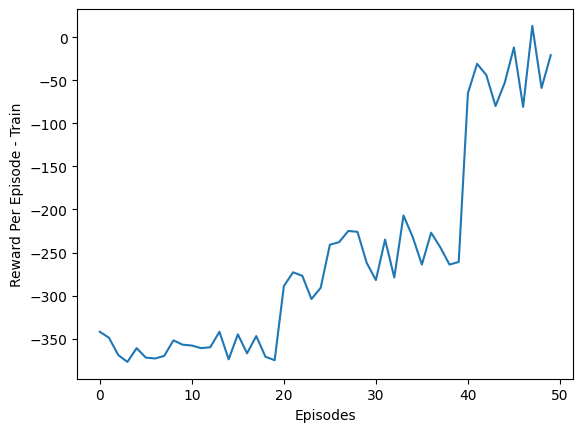

Testing...
The reward of the validation episode was  -263.0
The balanced accuracy was  0.2730518519413517


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

The reward of the validation episode was  -335.0
The balanced accuracy was  0.27343073917075916


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The reward of the validation episode was  -270.0
The balanced accuracy was  0.27305428023741146
The reward of the validation episode was  -347.0
The balanced accuracy was  0.27299559763732495
The reward of the validation episode was  -329.0
The balanced accuracy was  0.2730953998447205
The reward of the validation episode was  -241.0
The balanced accuracy was  0.2733037180479929


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The reward of the validation episode was  -366.0
The balanced accuracy was  0.27321680023718875
The reward of the validation episode was  -252.0
The balanced accuracy was  0.27304854907815806
The reward of the validation episode was  -271.0
The balanced accuracy was  0.27306170196414176
The reward of the validation episode was  -309.0
The balanced accuracy was  0.27296497354630117
The reward of the validation episode was  -337.0
The balanced accuracy was  0.27290728432500677
The reward of the validation episode was  -254.0
The balanced accuracy was  0.2729999400186181
The reward of the validation episode was  -322.0
The balanced accuracy was  0.27301229291345047
The reward of the validation episode was  -360.0
The balanced accuracy was  0.27307346445526515
The reward of the validation episode was  -249.0
The balanced accuracy was  0.2730490678689931
The reward of the validation episode was  -369.0
The balanced accuracy was  0.27305638285763906
The reward of the validation episode was  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The reward of the validation episode was  -182.0
The balanced accuracy was  0.272900447210604


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The reward of the validation episode was  -272.0
The balanced accuracy was  0.2728513427366969
The reward of the validation episode was  -256.0
The balanced accuracy was  0.2727919876693234
The reward of the validation episode was  -217.0
The balanced accuracy was  0.27275112317434785
The reward of the validation episode was  -331.0
The balanced accuracy was  0.27278334326143894
The reward of the validation episode was  -386.0
The balanced accuracy was  0.2729229525719291
The reward of the validation episode was  -259.0
The balanced accuracy was  0.2728863138673731
The reward of the validation episode was  -327.0
The balanced accuracy was  0.27283859099918734
The reward of the validation episode was  -340.0
The balanced accuracy was  0.2728465911650178
The reward of the validation episode was  -255.0
The balanced accuracy was  0.27283333956040084
The reward of the validation episode was  -215.0
The balanced accuracy was  0.2728780547457971
The reward of the validation episode was  -185

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The reward of the validation episode was  -212.0
The balanced accuracy was  0.27281150083383354
The reward of the validation episode was  -256.0
The balanced accuracy was  0.2728157241777075
The reward of the validation episode was  -210.0
The balanced accuracy was  0.27282660257425134
The reward of the validation episode was  -285.0
The balanced accuracy was  0.2728265289038205
The reward of the validation episode was  -452.0
The balanced accuracy was  0.27279996526963196
The reward of the validation episode was  -163.0
The balanced accuracy was  0.27281061318473165


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The reward of the validation episode was  -450.0
The balanced accuracy was  0.2728159752856922
The reward of the validation episode was  -437.0
The balanced accuracy was  0.2727885921426213
The reward of the validation episode was  -228.0
The balanced accuracy was  0.27278085102920546
The reward of the validation episode was  -290.0
The balanced accuracy was  0.27274121462497974
The reward of the validation episode was  -374.0
The balanced accuracy was  0.27269398166807435
The reward of the validation episode was  -310.0
The balanced accuracy was  0.2726952980322805
The reward of the validation episode was  -191.0
The balanced accuracy was  0.2726931148216816
The reward of the validation episode was  -261.0
The balanced accuracy was  0.27269624837491485
The reward of the validation episode was  -259.0
The balanced accuracy was  0.27267685914528766
The reward of the validation episode was  -126.0
The balanced accuracy was  0.2726982099004899


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The reward of the validation episode was  -228.0
The balanced accuracy was  0.27267083293959293
The reward of the validation episode was  -385.0
The balanced accuracy was  0.2726580902093733
The reward of the validation episode was  -294.0
The balanced accuracy was  0.2726329089393868
The reward of the validation episode was  -286.0
The balanced accuracy was  0.27271219332582597
The reward of the validation episode was  -67.0
The balanced accuracy was  0.2726872776961418


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The reward of the validation episode was  -430.0
The balanced accuracy was  0.27272544753060773
The reward of the validation episode was  -511.0
The balanced accuracy was  0.2727217479090382
The reward of the validation episode was  -328.0
The balanced accuracy was  0.27268664376381657
The reward of the validation episode was  -220.0
The balanced accuracy was  0.2726677694912568
The reward of the validation episode was  -356.0
The balanced accuracy was  0.2726747656900613
The reward of the validation episode was  -223.0
The balanced accuracy was  0.27271033566225195
The reward of the validation episode was  -232.0
The balanced accuracy was  0.2727267397354588
The reward of the validation episode was  -275.0
The balanced accuracy was  0.27274450546652657
The reward of the validation episode was  -176.0
The balanced accuracy was  0.27273844478664483
The reward of the validation episode was  -158.0
The balanced accuracy was  0.272756291054406
The reward of the validation episode was  -205

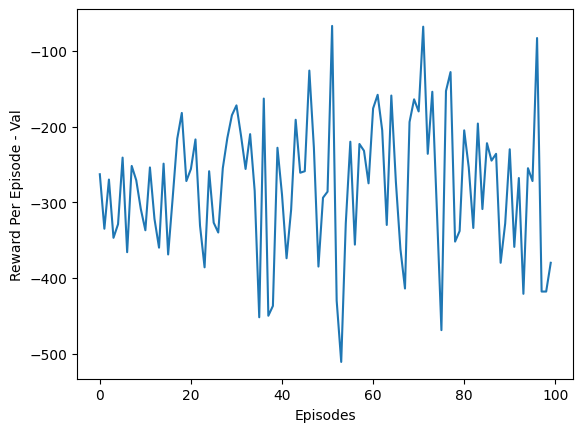

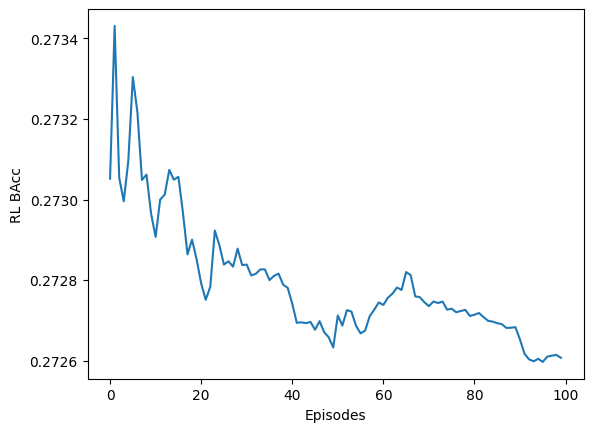

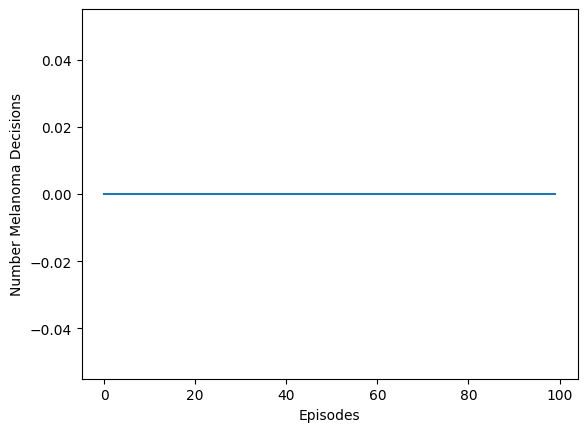

Evaluating...
State shape: (519,)
Number actions: Discrete(7)
Observation space: Box(-inf, inf, (7,), float32)
State shape: (519,)
Number actions: Discrete(7)
Observation space: Box(-inf, inf, (7,), float32)
State shape: (519,)
Number actions: Discrete(7)
Observation space: Box(-inf, inf, (7,), float32)
State shape: (519,)
Number actions: Discrete(7)
Observation space: Box(-inf, inf, (7,), float32)
State shape: (519,)
Number actions: Discrete(7)
Observation space: Box(-inf, inf, (7,), float32)


In [ ]:
#### Import Datasets ####
tf1.enable_eager_execution()

database = pd.read_csv('vectorDBNoSpace.csv')

print(database)

database.head()

labels = np.asarray(database['dx'])

print(labels)

labels[labels == 'scc'] = 'akiec'

le = preprocessing.LabelEncoder()

le.fit(labels)

vocab = le.classes_

n_words = len(vocab)

features1 = np.load("nmed_rn34_ham10k_vectors.npy")

features2 = pd.read_csv("vectorDBNoSpace.csv")

features2.pop('dx')

features2 = np.asarray(features2, dtype='float32')

features = np.concatenate([features1,features2],axis=1)


_, counts = np.unique(labels, return_counts=True)

print(counts)

counts = counts/np.sum(counts)


labels_cat = le.transform(labels)

print(labels_cat.dtype)

train_feat, val_feat, train_labels, val_labels = train_test_split(features, labels_cat, test_size=0.2,
                                                                      random_state=111,stratify = labels_cat)


_, count_train = np.unique(val_labels, return_counts=True)

print(count_train)

patients = initialize_clinical_practice(train_feat,train_labels,train_labels.shape[0],True,n_words, 150,counts)

patients_val = initialize_clinical_practice(val_feat,val_labels,val_labels.shape[0],False,n_words, 150,counts)


trained_agent, env = train(iterations = 10, episodes=5, patients= patients, vocab=vocab, n_words = n_words)

test_agent = trained_agent.copy()

print("Testing...")
test(test_agent,patients, env)

print("Evaluating...")
for _ in range(5):
    eval(test_agent,patients_val)